# Install Dependencies

In [1]:
!pip install torch_summary

# Import Libraries

In [2]:
import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms as T, models
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from tqdm.notebook import tqdm 
import zipfile

from sklearn.metrics import classification_report, recall_score, accuracy_score, f1_score, precision_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from random import shuffle, randint, choice
import numpy as np
import cv2 as cv
from glob import glob
import pandas as pd
import requests
import concurrent.futures

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
!mkdir saved_model
sns.set_theme()
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Dataset

In [4]:
DIR = '/kaggle/input/diabetic-retinopathy-detection'

with zipfile.ZipFile(f'{DIR}/trainLabels.csv.zip', 'r') as zip_ref:
    with zip_ref.open('trainLabels.csv') as csv_file:
        trainLabels_df = pd.read_csv(csv_file, index_col=0).reset_index()

trainLabels_df.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [5]:
print("Total:", len(trainLabels_df))
print("Stage 0:", len(trainLabels_df[trainLabels_df["level"]==0]))
print("Stage 1:", len(trainLabels_df[trainLabels_df["level"]==1]))
print("Stage 2:", len(trainLabels_df[trainLabels_df["level"]==2]))
print("Stage 3:", len(trainLabels_df[trainLabels_df["level"]==3]))
print("Stage 4:", len(trainLabels_df[trainLabels_df["level"]==4]))

Total: 35126
Stage 0: 25810
Stage 1: 2443
Stage 2: 5292
Stage 3: 873
Stage 4: 708


In [6]:
trainLabels_df = trainLabels_df[trainLabels_df['level'] != 1]
trainLabels_df = trainLabels_df[trainLabels_df['level'] != 2]
trainLabels_df['level'] = np.where(trainLabels_df['level'] == 0, 0, 1)
print("Diabetic negative:", len(trainLabels_df[trainLabels_df["level"]==0]))
print("Diabetic positive:", len(trainLabels_df[trainLabels_df["level"]==1]))

Diabetic negative: 25810
Diabetic positive: 1581


In [7]:
negative_df = trainLabels_df[trainLabels_df["level"]==0].sample(1200)
positive_df = trainLabels_df[trainLabels_df["level"]==1].sample(1200)

negative_train, negative_valid = train_test_split(negative_df, test_size=0.2, random_state=42)
positive_train, positive_valid = train_test_split(positive_df, test_size=0.2, random_state=42)

train_df = pd.concat([negative_train, positive_train]).sample(frac=1).reset_index()
valid_df = pd.concat([negative_valid, positive_valid]).sample(frac=1).reset_index()


In [8]:
def download_image(index, image_name, df, count, total):
    filepath = f"https://diabetic-retinopathy-images.s3.ap-southeast-1.amazonaws.com/images/{image_name}.jpeg" 
    response = requests.get(filepath)
    print(count, "/", total, response.reason, image_name, end="\r")
    if response.status_code != 200:
        df.drop(index, inplace=True)
        return None
    image_data = response.content
    nparr = np.frombuffer(image_data, np.uint8)
    image = cv.imdecode(nparr, cv.IMREAD_COLOR)
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    df.at[index, 'imagefile'] = image

In [9]:
train_df['imagefile'] = None
total = len(train_df)
count = 1

for start in range(0, total, 1000):
    end = min(start + 1000, total)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for index, row in train_df[start:end].iterrows():
            image_name = row['image']
            future = executor.submit(download_image, index, image_name, train_df, count, total)
            futures.append(future)
            count += 1
        concurrent.futures.wait(futures)
    
print("Done!")

Done!


In [10]:
valid_df['imagefile'] = None
total = len(valid_df)
count = 1

for start in range(0, total, 1000):
    end = min(start + 1000, total)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for index, row in valid_df[start:end].iterrows():
            image_name = row['image']
            future = executor.submit(download_image, index, image_name, valid_df, count, total)
            futures.append(future)
            count += 1
        concurrent.futures.wait(futures)

print("Done!")

Done!


In [11]:
def crop_center(cv2_img, crop_width, crop_height):
    img_height, img_width = cv2_img.shape[:2]
    left = (img_width - crop_width) // 2
    top = (img_height - crop_height) // 2
    right = (img_width + crop_width) // 2
    bottom = (img_height + crop_height) // 2
    return cv2_img[top:bottom, left:right]

In [12]:
class EyeDataset(Dataset):
    def __init__(self, df, data_transform = None):
        self.df = df
        self.data_transform = data_transform
        self.transform = T.Compose([
            T.Resize([224, 224]),
            T.ToTensor(),
            T.Normalize(mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225))
        ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        image = self.df.iloc[idx]['imagefile']
        crop_size = min(image.shape[:2])
        cropped_image = cv.cvtColor(crop_center(image, crop_size, crop_size), cv.COLOR_GRAY2RGB)
        cropped_image = Image.fromarray(cropped_image)
        
        target = self.df.iloc[idx]['level']
        
        if self.data_transform is not None:
            cropped_image = self.data_transform(cropped_image)
        
        return cropped_image, target
    
    def transform_img(self, img):
        return self.transform(img)
    
    def collate_fn(self, data):
        imgs, targets = zip(*data)
        targets = torch.tensor(targets)
        targets = targets.view(-1, 1).float()
        targets = targets.to(device)
        imgs = torch.stack(
            [self.transform_img(img) for img in imgs], 0
        ).to(device)
        return imgs, targets

In [13]:
data_transforms = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.RandomResizedCrop(224, scale=(0.8, 1.0))
])

In [14]:
train_ds = EyeDataset(train_df, data_transform=data_transforms)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True,
                      collate_fn=train_ds.collate_fn)

valid_ds = EyeDataset(valid_df)
valid_dl = DataLoader(valid_ds, batch_size=64,
                      collate_fn=valid_ds.collate_fn)

In [15]:
class EyeClassifier(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        
        self.model = models.resnet50(pretrained=pretrained, progress=pretrained)
    
        for param in self.model.parameters():
            param.requires_grad = True
        
        num_features = self.model.fc.in_features

        self.model.fc = nn.Sequential(
            nn.Flatten(),
            nn.BatchNorm1d(num_features),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(num_features, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [16]:
classifier = EyeClassifier(pretrained=True)
_ = summary(classifier, torch.ones(1,3,224,224))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 227MB/s]


Layer (type:depth-idx)                   Output Shape              Param #
├─ResNet: 1-1                            [-1, 1]                   --
|    └─Conv2d: 2-1                       [-1, 64, 112, 112]        9,408
|    └─BatchNorm2d: 2-2                  [-1, 64, 112, 112]        128
|    └─ReLU: 2-3                         [-1, 64, 112, 112]        --
|    └─MaxPool2d: 2-4                    [-1, 64, 56, 56]          --
|    └─Sequential: 2-5                   [-1, 256, 56, 56]         --
|    |    └─Bottleneck: 3-1              [-1, 256, 56, 56]         75,008
|    |    └─Bottleneck: 3-2              [-1, 256, 56, 56]         70,400
|    |    └─Bottleneck: 3-3              [-1, 256, 56, 56]         70,400
|    └─Sequential: 2-6                   [-1, 512, 28, 28]         --
|    |    └─Bottleneck: 3-4              [-1, 512, 28, 28]         379,392
|    |    └─Bottleneck: 3-5              [-1, 512, 28, 28]         280,064
|    |    └─Bottleneck: 3-6              [-1, 512, 28, 28] 

In [17]:
def train(data, classifier, optimizer, loss_fn):
    classifier.train()
    imgs, targets = data
    outputs = classifier(imgs.to(device))
    loss = loss_fn(outputs.to(device), targets.to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    outputs = outputs.cpu().detach().tolist()
    targets = targets.cpu().detach().tolist()
    preds = list(map(lambda x: int(x[0] > 0.5), outputs))
    
    fake_recall_score = recall_score(targets, preds, pos_label=0,zero_division=0)
    fake_accuracy_score = accuracy_score(targets, preds)
    fake_precision_score = precision_score(targets, preds, pos_label=0,zero_division=0)
    fake_f1_score = f1_score(targets, preds, pos_label=0,zero_division=0)
    fpr, tpr, thresholds = roc_curve(targets, outputs)
    roc_auc = auc(fpr, tpr)
    
    return loss.cpu().detach().item(), fake_recall_score, fake_accuracy_score, fake_precision_score, fake_f1_score, fpr, tpr, roc_auc

In [18]:
@torch.no_grad()
def validate(data, classifier, loss_fn):
    classifier.eval()
    imgs, targets = data
    outputs = classifier(imgs.to(device))
    loss = loss_fn(outputs.to(device), targets.to(device))
    
    outputs = outputs.cpu().detach().tolist()
    targets = targets.cpu().detach().tolist()
    preds = list(map(lambda x: int(x[0] > 0.5), outputs))
    fake_recall_score = recall_score(targets, preds, pos_label=0, zero_division=0)
    fake_accuracy_score = accuracy_score(targets, preds)
    fake_precision_score = precision_score(targets, preds, pos_label=0,zero_division=0)
    fake_f1_score = f1_score(targets, preds, pos_label=0,zero_division=0)
    fpr, tpr, thresholds = roc_curve(targets, outputs)
    roc_auc = auc(fpr, tpr)
    
    return loss.cpu().detach().item(), fake_recall_score, fake_accuracy_score, fake_precision_score, fake_f1_score, fpr, tpr, roc_auc

In [19]:
classifier = EyeClassifier(pretrained=True).to(device)
loss_fn = nn.BCELoss().to(device)
optimizer = optim.Adam(classifier.parameters(), lr=1e-3, weight_decay=1e-3)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5,
                                      gamma=0.25)
best_recall_score = 0
n_epochs = 15
xticks = list(i+1 for i in range(n_epochs))

In [20]:
mem = {
    'train_loss': [],
    'train_recall_score': [],
    'train_accuracy_score': [],
    'train_precision_score': [],
    'train_f1_score': [],
    'train_tpr': [],
    'train_fpr': [],
    'train_auc': [],
    'valid_loss': [],
    'valid_recall_score': [],
    'valid_accuracy_score': [],
    'valid_precision_score': [],
    'valid_f1_score': [],
    'valid_tpr': [],
    'valid_fpr': [],
    'valid_auc': [],
}

for epoch in tqdm(range(n_epochs), desc='Training'):
    n_batch = len(train_dl)
    train_losses, train_recall_scores, train_accuracy_scores, train_precision_scores, train_f1_scores, train_tprs, train_fprs, train_aucs = [], [], [], [], [], [], [], []
    for i, data in enumerate(train_dl):
        train_loss, train_recall_score, train_accuracy_score, train_precision_score, train_f1_score, train_tpr, train_fpr, train_auc = train(data, classifier, optimizer, loss_fn)
        train_losses.append(train_loss)
        train_recall_scores.append(train_recall_score)
        train_accuracy_scores.append(train_accuracy_score)
        train_precision_scores.append(train_precision_score)
        train_f1_scores.append(train_f1_score)
        train_tprs.append(train_tpr)
        train_fprs.append(train_fpr)
        train_aucs.append(train_auc)
        pos = epoch + ((i+1)/n_batch)
        print(
            'epoch:', "%.3f" % pos,
            '\ttrain loss:', "%.3f" % train_loss,
            '\ttrain recall score:', "%.3f" % train_recall_score, 
            '\ttrain accuracy score:', "%.3f" % train_accuracy_score, 
            '\ttrain precision score:', "%.3f" % train_precision_score, 
            '\ttrain f1 score:', "%.3f" % train_f1_score, 
            '\ttrain auc:', "%.3f" % train_auc, 
            end='\r'
        )
        
    mem['train_loss'].append(np.mean(train_losses))
    mem['train_recall_score'].append(np.mean(train_recall_scores))
    mem['train_accuracy_score'].append(np.mean(train_accuracy_scores))
    mem['train_precision_score'].append(np.mean(train_precision_scores))
    mem['train_f1_score'].append(np.mean(train_f1_scores))
    mem['train_tpr'].append(np.concatenate(train_fprs))
    mem['train_fpr'].append(np.concatenate(train_tprs))
    mem['train_auc'].append(np.mean(train_aucs))
    
    n_batch = len(valid_dl)
    valid_losses, valid_recall_scores, valid_f1_scores, valid_accuracy_scores, valid_precision_scores, valid_tprs, valid_fprs, valid_aucs =  [], [], [], [], [], [], [], []
    for i, data in enumerate(valid_dl):
        valid_loss, valid_recall_score, valid_accuracy_score, valid_precision_score, valid_f1_score, valid_tpr, valid_fpr, valid_auc = validate(data, classifier, loss_fn)
        valid_losses.append(valid_loss)
        valid_recall_scores.append(valid_recall_score)
        valid_accuracy_scores.append(valid_accuracy_score)
        valid_precision_scores.append(valid_precision_score)
        valid_f1_scores.append(valid_f1_score)
        valid_tprs.append(valid_tpr)
        valid_fprs.append(valid_fpr)
        valid_aucs.append(valid_auc)
        pos = epoch + ((i+1)/n_batch)
        print(
            'epoch:', "%.3f" % pos,
            '\tvalid loss:', "%.3f" % valid_loss,
            '\tvalid recall score:', "%.3f" % valid_recall_score, 
            '\tvalid accuracy score:', "%.3f" % valid_accuracy_score, 
            '\tvalid precision score:', "%.3f" % valid_precision_score, 
            '\tvalid f1 score:', "%.3f" % valid_f1_score, 
            '\tvalid auc:', "%.3f" % valid_auc, 
            end='\r'
        )
    
    cur_recall_score = np.mean(valid_recall_scores)
    mem['valid_loss'].append(np.mean(valid_losses))
    mem['valid_recall_score'].append(np.mean(valid_recall_scores))
    mem['valid_accuracy_score'].append(np.mean(valid_accuracy_scores))
    mem['valid_precision_score'].append(np.mean(valid_precision_scores))
    mem['valid_f1_score'].append(np.mean(valid_f1_scores))
    mem['valid_tpr'].append(np.concatenate(valid_fprs))
    mem['valid_fpr'].append(np.concatenate(valid_tprs))
    mem['valid_auc'].append(np.mean(valid_aucs))
    
    print(
        'epoch:', epoch+1,
        '\ttrain loss:', "%.3f" % mem['train_loss'][-1],
        '\ttrain recall score:', "%.3f" % mem['train_recall_score'][-1],
        '\ttrain accuracy score:', "%.3f" % mem['train_accuracy_score'][-1],
        '\ttrain precision score:', "%.3f" % mem['train_precision_score'][-1],
        '\ttrain f1 score:', "%.3f" % mem['train_f1_score'][-1],
        '\ttrain auc:', "%.3f" % mem['train_auc'][-1],
        '\tvalid loss:', "%.3f" % mem['valid_loss'][-1],
        '\tvalid recall score:', "%.3f" % mem['valid_recall_score'][-1],
        '\tvalid accuracy score:', "%.3f" % mem['valid_accuracy_score'][-1],
        '\tvalid precision score:', "%.3f" % mem['valid_precision_score'][-1],
        '\tvalid f1 score:', "%.3f" % mem['valid_f1_score'][-1],
        '\tvalid auc:', "%.3f" % mem['valid_auc'][-1],
    )
    
    if epoch > 5 and best_recall_score < cur_recall_score:
        best_recall_score = cur_recall_score
        torch.save(classifier.state_dict(), './saved_model/diabetic_state_dict.pth')
        torch.save(classifier, './saved_model/diabetic_model.pth')
        
    scheduler.step()

Training:   0%|          | 0/15 [00:00<?, ?it/s]

epoch: 1 	train loss: 0.558 	train recall score: 0.763 	train accuracy score: 0.739 	train precision score: 0.732 	train f1 score: 0.741 	train auc: 0.821 	valid loss: 5.751 	valid recall score: 0.049 	valid accuracy score: 0.531 	valid precision score: 0.812 	valid f1 score: 0.091 	valid auc: 0.808
epoch: 2 	train loss: 0.380 	train recall score: 0.842 	train accuracy score: 0.832 	train precision score: 0.828 	train f1 score: 0.831 	train auc: 0.914 	valid loss: 3.728 	valid recall score: 0.929 	valid accuracy score: 0.639 	valid precision score: 0.580 	valid f1 score: 0.711 	valid auc: 0.621
epoch: 3 	train loss: 0.346 	train recall score: 0.863 	train accuracy score: 0.852 	train precision score: 0.849 	train f1 score: 0.853 	train auc: 0.929 	valid loss: 0.458 	valid recall score: 0.787 	valid accuracy score: 0.783 	valid precision score: 0.762 	valid f1 score: 0.771 	valid auc: 0.873
epoch: 4 	train loss: 0.353 	train recall score: 0.871 	train accuracy score: 0.853 	train precis

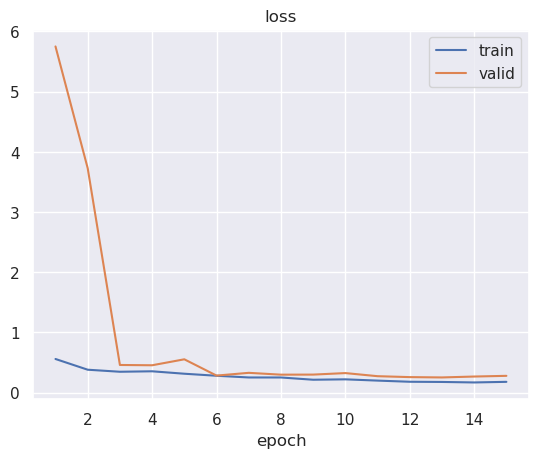

In [21]:
plt.plot(xticks, mem['train_loss'])
plt.plot(xticks, mem['valid_loss'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('loss')
plt.show()

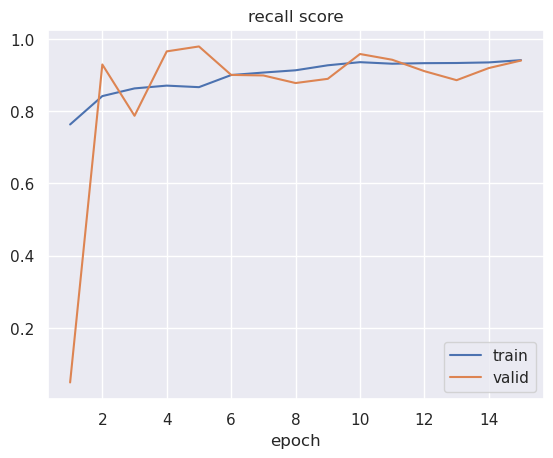

In [22]:
plt.plot(xticks, mem['train_recall_score'])
plt.plot(xticks, mem['valid_recall_score'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('recall score')
plt.show()

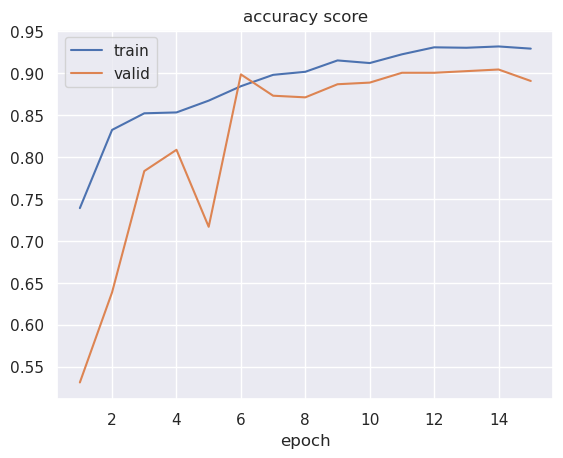

In [23]:
plt.plot(xticks, mem['train_accuracy_score'])
plt.plot(xticks, mem['valid_accuracy_score'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('accuracy score')
plt.show()

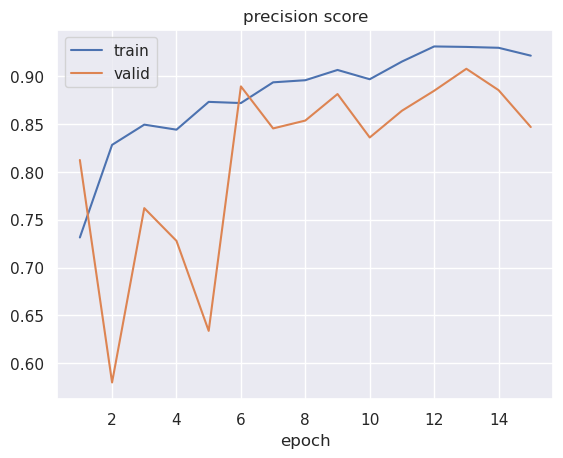

In [24]:
plt.plot(xticks, mem['train_precision_score'])
plt.plot(xticks, mem['valid_precision_score'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('precision score')
plt.show()

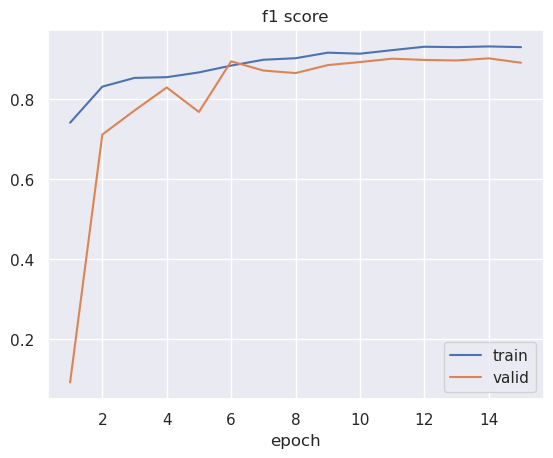

In [25]:
plt.plot(xticks, mem['train_f1_score'])
plt.plot(xticks, mem['valid_f1_score'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('f1 score')
plt.show()

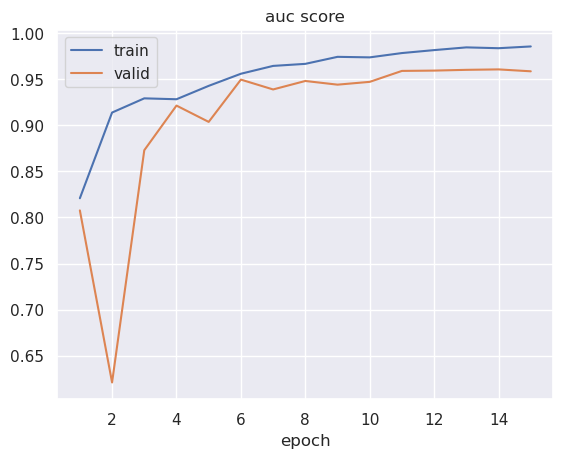

In [26]:
plt.plot(xticks, mem['train_auc'])
plt.plot(xticks, mem['valid_auc'])
plt.legend(['train', 'valid'])
plt.xlabel('epoch')
plt.title('auc score')
plt.show()